# OLD NOTEBOOK- Admissions distributions by Age and Diagnosis- now superceded by admissions distributions by cluster and ICU

## Aims and objectives

Outputs of this notebook were intended to be inputs to the ABM, but were superceded by intime distrbutions based on cluster and ICU.

- Patient intime distributions per age group and diagnosis; these provide parameters from which we perform multinomial draws to admit patients to hospital as part of the ABM, one of the core stochastic elements of the model.
- Investigations into sparsity of intime data

Comments
- Trade off between model accuracy (additional features used in best estimator models) versus created too sparse distributions to estimate intime frequency. That is why we create patient clusters instead of using age and diagnosis 

# Install packages

In [4]:
from collections import Counter
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Load files

In [8]:
os.chdir("/Users/chloemaine/Documents/Chloe/BGSE/masters_project/processed_data")

df = pd.read_csv('patient_details_idealicu.csv')

# Define functions

In [9]:
# Subset a dataframe based on columns from 2 lists
def subset_df(list_1, list_2, df):
    
    subset = []
    for i in range(0, max(len(list_1), len(list_2))):
        try:
            subset.append(list_1[i])
        except: pass
        try:
            subset.append(list_2[i])
        except: pass

    return(df.loc[:, subset])

# Extracts day from intime col
def extract_day(df, intime_cols):
    
    for col in intime_cols:
        col_name = str(col) + "_day"
        df.loc[:, str(col)] = pd.to_datetime(df.loc[:, str(col)])
        df.insert(df.shape[1], str(col_name), df.loc[:,str(col)].dt.date, True) 
    
    return(df)

# Caclulate intime distribution for each diagnosis and for each age group within diagnosis
def calculate_intime_distribution(dataframe,
                                  unique_ICD9_codes, dcol,
                                  unique_ages, acol,
                                  id_col = 'INTIME_day', total_days = 4170): 
    
    df = dataframe
    results = []
    a_results = []
    a_colnames = []
    i=0

    for icd9 in unique_ICD9_codes: 

        subset = df.loc[df.loc[:,str(dcol)] == icd9,]  # Select rows from df for one diagnosis at a time
        # Group by day and count number of days where 1,2,3,4,5 people were admitted
        by_day = subset.groupby(str(id_col)).INTIME.count()
        counter = Counter(list(by_day))

        # Add results to dataframe
        temp_results = []
        for j in np.arange(0,7):
            temp_results.append(counter[j])
        results.append(temp_results)
        i+=1
        
        
        # Group by day and count the number of days where 1,2,3,4,5 people were admitted
        by_day2 = subset.groupby('age_group').age_group.count()
        a_results.append(by_day2)
        a_colnames.append(str(icd9))

    results = pd.DataFrame(results)
    a_results = pd.DataFrame(a_results)
    
    # Infer days when no-one was admitted (using total days - days when someone was admitted)
    results['0'] = total_days - results.sum(axis=1)

    # Drop redundant 0 column
    results = results.iloc[:, 1:8] 
    
    # Convert from counts to probabilities
    results = results /total_days 

    
    # Format for output
    results = results.transpose() 
    a_results = a_results.transpose()
    results.columns = unique_ICD9_codes 
    a_results.columns = a_colnames
    
    final = list([results, a_results])
    return(final)

# Loops the above function for all ICUs
def calculate_intime_distribution_pericu (dataframe,
                                          unique_ICD9_codes, dcol,
                                          unique_ages, acol,
                                          unique_icus, 
                                          icucol = 'FIRST_CAREUNIT',  id_col = 'INTIME_day',
                                          total_days = 4170): 

    aprob_list = []
    dprob_list = []
    df = dataframe
    bin_sizes = []

    for icu in unique_icus:

        subset = df.loc[df.loc[:,str(icucol)] == icu,]
        # Calculate intime distribution for diagnosis and ages for all ICUs
        dprobs, aprobs = calculate_intime_distribution(subset,
                                                       unique_ICD9_codes, dcol,
                                                       unique_ages, acol)
        dprob_list.append(dprobs)
        bin_sizes.append(aprobs)
        aprobs = aprobs / aprobs.sum(axis=0)
        aprobs = aprobs.fillna(0)
        aprob_list.append(aprobs)
        
    return(list([dprob_list, aprob_list, bin_sizes]))


# Create dictionary of LOS based on best estimates from our regression models.
# Note that the input df must contain the same prediction for each unique combination!
def create_dict_LOS(dataframe, unique_icus, unique_diagnoses, unique_ages,
                   dcol = 'first_category', acol = 'age_group', icucol = 'FIRST_CAREUNIT',
                   w_icu = 'true'): # w_icu argument allows us to specify whether the returning dictionary includes icu as a property of each agent or not
    
    df = dataframe
    dict_LOS = {}
    
    if w_icu == 'true':
    
        for icu in unique_icus:
            for d in unique_diagnoses:
                for age in unique_ages:
                    
                    subset= df.loc[df.loc[:, str(dcol)] == d,]
                    subset2 = subset.loc[subset.loc[:, str(acol)] == age,]
                    subset3 = subset2.loc[subset.loc[:, str(icucol)]== icu,]
    #                 print(subset3.model_predictions) # This line allows you to check that we have the same prediction for each type of agent
                    idx = str(icu) + "_" + str(d) + "_" + str(age)
                    dict_LOS[str(idx)] = np.mean(subset3.model_predictions) # Mean here not required as they all have same value!
            
    elif w_icu == 'false':
        
        for d in unique_diagnoses:
            for age in unique_ages:


                subset= df.loc[df.loc[:, str(dcol)] == d,]
                subset2 = subset.loc[subset.loc[:, str(acol)] == age,]
    #                 print(subset3.model_predictions) # This line allows you to check that we have the same prediction for each type of agent
                idx = str(d) + "_" + str(age)
                dict_LOS[str(idx)] = np.mean(subset2.model_predictions) # Mean here not required as they all have same value!
        
    
    return(dict_LOS)

# # CODE TO TEST WHETHER WE HAVE ONE PREDICTION PER TYPE OF AGENT

# subset= df.loc[df.loc[:,'first_category'] == 'congenital',]
# subset2 = subset.loc[subset.loc[:,'age_group'] == '60-79',]
# subset3 = subset2.loc[subset.loc[:, 'FIRST_CAREUNIT']=='CSRU',]
# subset3

# subset= df.loc[df.loc[:,'first_category'] == 'digestive',]
# subset2 = subset.loc[subset.loc[:,'age_group'] == '40-59',]
# subset3 = subset2.loc[subset.loc[:, 'FIRST_CAREUNIT']=='TSICU',]
# subset3

# Run code for true ICUs

In [13]:
df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender', 'dod', 'admittime',
       'dischtime', 'los_hospital', 'age', 'ethnicity', 'ethnicity_grouped',
       'admission_type', 'hospital_expire_flag', 'hospstay_seq',
       'first_hosp_stay', 'intime', 'outtime', 'los_icu', 'icustay_seq',
       'first_icu_stay', 'SUBJECT_ID', 'HADM_ID', 'CURR_SERVICE',
       'PREV_SERVICE', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID', 'LOS',
       'ICUSTAY_ID', 'FIRST_CAREUNIT', 'best_ICU', 'match_ICU', 'ideal_ICU'],
      dtype='object')

In [141]:
# Subset dataframe to only required columns
essentials = [ 'INTIME', 'ideal_ICU', 'model_predictions']    # Those needed to caluclate intime dists    
predictors = ['age_group', 'gender', 'first_category'] # Those for which we use to predict LOS

df1 = subset_df(essentials, predictors, df)
df_wo_1 = subset_df(essentials, predictors, df_wo)

# Create unique lists of predictors
unique_predictors = []
for pred in predictors:
     unique_predictors.append(df1.groupby(pred).count().index)
unique_predictors.append(df1.groupby('FIRST_CAREUNIT').count().index)

# # Save lists to file
import pickle
with open('unique_predictors.pkl', 'wb') as f:
       pickle.dump(unique_predictors, f)

# Extract intime day from relevant columns
df1 = extract_day(df1, ['INTIME'])

# Calculate intime distribution for diagnosis and ages for all ICUs
dprobs, aprobs = calculate_intime_distribution(df1,
                                               unique_predictors[2], 'first_category',
                                               unique_predictors[0], 'age_group')

# Calculate intime distribution for diagnosis and ages per icu
dprob_list, aprob_list, bin_sizes = calculate_intime_distribution_pericu(df1,
                                                      unique_predictors[2], 'first_category',
                                                      unique_predictors[0], 'age_group',
                                                      unique_predictors[3])
# Save lists to file
import pickle
with open('dprob_list.pkl', 'wb') as f:
       pickle.dump(dprob_list, f)

import pickle
with open('aprob_list.pkl', 'wb') as f:
       pickle.dump(aprob_list, f)

# Create dictionary of Length of stay for each type of agent -with ICU included
dict_LOS = create_dict_LOS(df1,  unique_predictors[3],  unique_predictors[2], unique_predictors[0]) 
dict_LOS_wout_ICU = create_dict_LOS(df_wo_1,  unique_predictors[3],  unique_predictors[2], unique_predictors[0],
                                    w_icu = 'false')

# # Save LOS dictionary to filE
import pickle
with open('dict_LOS.pkl', 'wb') as f:
       pickle.dump(dict_LOS, f)
        
import pickle
with open('dict_LOS_wout_icu.pkl', 'wb') as f:
       pickle.dump(dict_LOS_wout_ICU, f)

In [142]:
aprob_list[1]

,blood,circulatory,congenital,digestive,genitourinary,ill-defined,infectious|parasitic,injury|poisoning,mental,metabolic|immunity,musculoskeletal,neoplasms,nervous,perinatal,pregnancy complications,respiratory,skin,unclassified
80-100,1.0,0.204910,0.000000,0.210526,0.0,0.25,0.000000,0.179688,0.0,0.2,0.000000,0.078947,0.500000,0.0,0.0,0.333333,0.0,0.0
0-19,0.0,0.000944,0.000000,0.000000,0.0,0.00,0.000000,0.031250,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
20-39,0.0,0.021719,0.217391,0.052632,0.0,0.00,0.111111,0.078125,1.0,0.0,0.000000,0.131579,0.166667,0.0,1.0,0.060606,0.0,0.0
40-59,0.0,0.226629,0.478261,0.421053,0.5,0.25,0.277778,0.265625,0.0,0.3,0.666667,0.131579,0.166667,0.0,0.0,0.242424,0.5,0.0
60-79,0.0,0.545798,0.304348,0.315789,0.5,0.50,0.611111,0.445312,0.0,0.5,0.333333,0.657895,0.166667,0.0,0.0,0.363636,0.5,1.0


In [116]:
dprob_list[1]

first_category,blood,circulatory,congenital,digestive,genitourinary,ill-defined,infectious|parasitic,injury|poisoning,mental,metabolic|immunity,musculoskeletal,neoplasms,nervous,perinatal,pregnancy complications,respiratory,skin,unclassified
1,0.000719,0.185132,0.005036,0.004556,0.00048,0.001918,0.004317,0.027338,0.00024,0.002398,0.000719,0.009113,0.001439,0.0,0.00024,0.007434,0.00048,0.00024
2,0.000000,0.029976,0.000240,0.000000,0.00000,0.000000,0.000000,0.000959,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000240,0.00000,0.00000
3,0.000000,0.002638,0.000000,0.000000,0.00000,0.000000,0.000000,0.000480,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.00000,0.00000
4,0.000000,0.000240,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.00000,0.00000
5,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.00000,0.00000
6,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.00000,0.00000
0,0.999281,0.782014,0.994724,0.995444,0.99952,0.998082,0.995683,0.971223,0.99976,0.997602,0.999281,0.990887,0.998561,1.0,0.99976,0.992326,0.99952,0.99976


In [117]:
dprobs

first_category,blood,circulatory,congenital,digestive,genitourinary,ill-defined,infectious|parasitic,injury|poisoning,mental,metabolic|immunity,musculoskeletal,neoplasms,nervous,perinatal,pregnancy complications,respiratory,skin,unclassified
1,0.008393,0.322062,0.010552,0.129496,0.033094,0.013189,0.122782,0.206475,0.024940,0.045564,0.018705,0.105755,0.031415,0.195923,0.004796,0.122302,0.006235,0.003597
2,0.000000,0.105276,0.000240,0.016067,0.002878,0.000959,0.011990,0.031175,0.001199,0.001918,0.000480,0.010791,0.001918,0.066187,0.000240,0.011031,0.000240,0.000000
3,0.000000,0.024221,0.000000,0.003357,0.000000,0.000000,0.000959,0.005755,0.000480,0.000240,0.000000,0.001199,0.000000,0.017266,0.000000,0.001918,0.000000,0.000000
4,0.000000,0.004796,0.000000,0.000240,0.000000,0.000000,0.000000,0.000959,0.000000,0.000000,0.000000,0.000240,0.000000,0.002638,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000240,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.991607,0.542686,0.989209,0.850839,0.964029,0.985851,0.864269,0.755635,0.973381,0.952278,0.980815,0.882014,0.966667,0.717746,0.994964,0.864748,0.993525,0.996403


# Sparsity of intime distributions

In [92]:
# Summaries for each ICU

#CCU
bin_sizes[0].sum(axis=0)

#CSRU
bin_sizes[1].sum(axis=0)

#MICU
bin_sizes[2].sum(axis=0)

#NICU
bin_sizes[3].sum(axis=0)

#SICU
bin_sizes[4].sum(axis=0)

#TSICU
bin_sizes[5].sum(axis=0)

unique_predictors[3]

# Totals
totals = bin_sizes[0].sum(axis=0) + bin_sizes[1].sum(axis=0) + bin_sizes[2].sum(axis=0) + bin_sizes[3].sum(axis=0) + bin_sizes[4].sum(axis=0)  + bin_sizes[5].sum(axis=0)

# Plot bin sizes for ICUs/diagnosis 

- Show sparsity of data for estimating intime diagnosis distributions per ICU

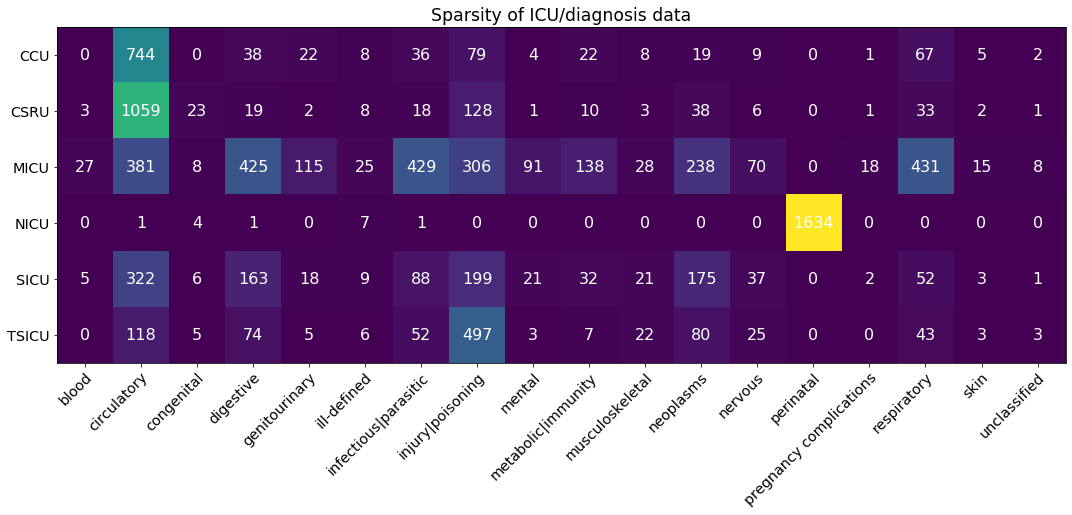

In [118]:
# Prepare dataframe
all_bins = []
for i in range(0,6):
    all_bins.append(bin_sizes[i].sum(axis=0).fillna(0))
all_bins = pd.DataFrame(all_bins).astype(int)
all_bins.index = unique_predictors[3]

# Name variables for plotting
icus = all_bins.index
diags = all_bins.columns
df = all_bins

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(df)

# We want to show all ticks...
ax.set_xticks(np.arange(len(diags)))
ax.set_yticks(np.arange(len(icus)))
ax.set_xticklabels(diags)
ax.set_yticklabels(icus, size = 'x-large')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor", size = 'x-large')

# Loop over data dimensions and create text annotations.
for i in range(len(icus)):
    for j in range(len(diags)):
        text = ax.text(j, i, df.iloc[i, j],
                       ha="center", va="center", color="w", fontsize = 16)

ax.set_title("Sparsity of ICU/diagnosis data", size = 'xx-large')
fig.tight_layout()

plt.show()

# Plot bin sizes for age/ diagnosis

- Show sparsity of data for estimating age/ diagnosis distributions

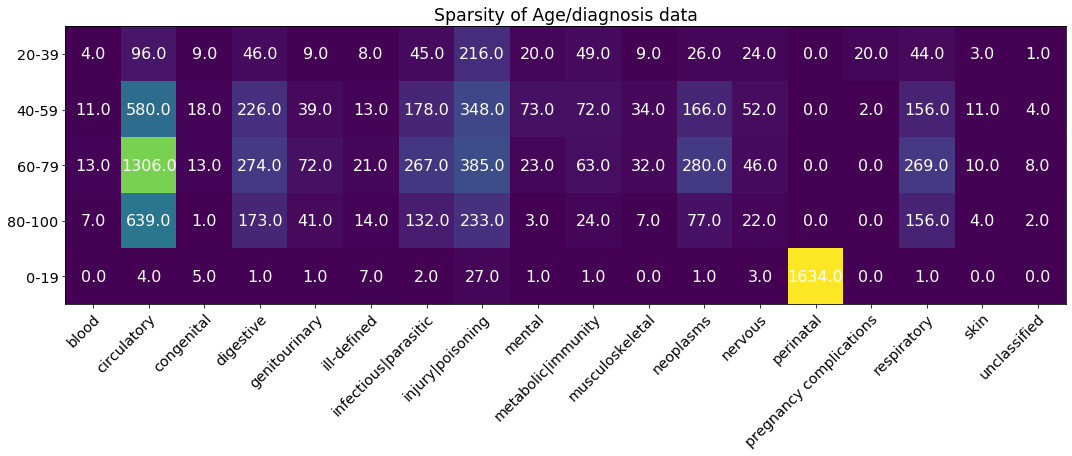

In [119]:
# Prepare dataframe
for icu in range(len(unique_predictors[3])):
    for bs in unique_predictors[0]:
        if bs not in bin_sizes[icu].index:
            bin_sizes[icu].loc[bs, :] = 0

# Prepare dataframe
all_bins = bin_sizes[0].fillna(0)
for i in range(1,6):
    all_bins += bin_sizes[i].fillna(0)
       
all_bins = pd.DataFrame(all_bins)

# Name variables for plotting
icus = all_bins.index
diags = all_bins.columns
df = all_bins


fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(df)

# We want to show all ticks...
ax.set_xticks(np.arange(len(diags)))
ax.set_yticks(np.arange(len(icus)))
ax.set_xticklabels(diags)
ax.set_yticklabels(icus, size = 'x-large')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor", size = 'x-large')

# Loop over data dimensions and create text annotations.
for i in range(len(icus)):
    for j in range(len(diags)):
        text = ax.text(j, i, df.iloc[i, j],
                       ha="center", va="center", color="w", fontsize = 16)

ax.set_title("Sparsity of Age/diagnosis data", size = 'xx-large')
fig.tight_layout()

plt.show()

Note sparsity of data in this table! We chose to create patient clusters as suggested in literature in order to model length of stay rather than use age and diagnosis as characteristics for each agent in our agent based model.